<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/covid-19predictCL/blob/master/covod_19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except OSError:
  print(tf.__version__)
finally:
  import tensorflow as tf
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  
  import requests as rq
  import io
  
  print(f'TF version: {tf.__version__}')
  
#  from google.colab import drive
#  drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)


TF version: 2.2.0-rc2


In [0]:
url = 'https://raw.githubusercontent.com/GUNTERMAXIMUS/covid-19predictCL/master/covid_19_data.csv'

respond = rq.get(url).content

df_data = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8')

df_train = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8')

In [3]:
df = df_data[df_data['Country/Region'].str.contains('Chile')].dropna()
df_train.dropna()
print(df.isnull().any())
df.tail(10)

ObservationDate    False
Country/Region     False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool


,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
7945,03/23/2020,Chile,746.0,2.0,11.0
8240,03/24/2020,Chile,922.0,2.0,17.0
8539,03/25/2020,Chile,1142.0,3.0,22.0
8841,03/26/2020,Chile,1306.0,4.0,22.0
9148,03/27/2020,Chile,1610.0,5.0,43.0
9455,03/28/2020,Chile,1909.0,6.0,61.0
9766,03/29/2020,Chile,2139.0,7.0,75.0
10078,03/30/2020,Chile,2449.0,8.0,156.0
10391,03/31/2020,Chile,2738.0,12.0,156.0
10704,04/01/2020,Chile,3031.0,16.0,234.0


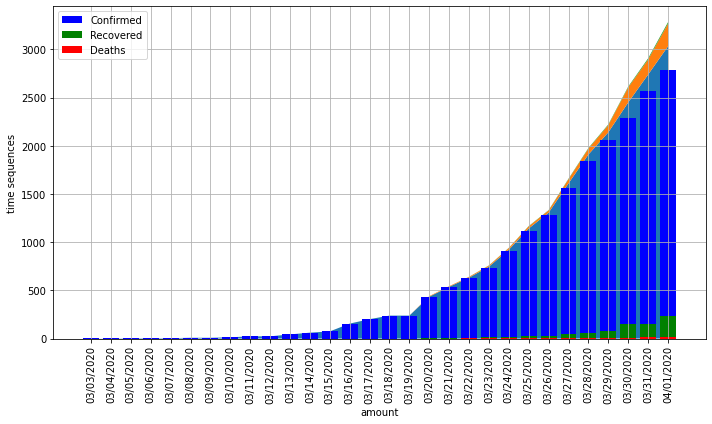

In [4]:
x = df.ObservationDate
y = (df.Confirmed) - (df.Recovered + df.Deaths)

plt.figure(figsize = (10, 6))
plt.bar(x, y, label = 'Confirmed', color = 'blue')
plt.bar(x, df.Recovered, label = 'Recovered', color = 'green')
plt.bar(x, df.Deaths, label = 'Deaths', color = 'red')
plt.stackplot(x, df.Confirmed, df.Recovered, df.Deaths)
plt.xlabel('amount')
plt.ylabel('time sequences')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.grid(True)

plt.show()

In [0]:
dates = df.ObservationDate
confirmed = np.array([int(i) for i in y]).reshape(-1, 1)
deaths = np.array([int(i) for i in df.Deaths]).reshape(-1, 1)
recovered = np.array([int(i) for i in df.Recovered]).reshape(-1, 1)
mortality_rate = np.array(df['Deaths'].tail(1) / df['Confirmed'].tail(1).sum()).reshape(-1, 1)

confirmed_total = df.Confirmed.tail(1)

days = np.array([i for i in range(len(dates))]).reshape(-1, 1)
deaths_total = np.array(df.Deaths.tail(1)).reshape(-1, 1)
recovered_total = np.array(df.Recovered.tail(1)).reshape(-1, 1)

In [0]:
days_future = 10
future_forecast_days = np.array([i for i in range(len(dates) + days_future)]).reshape(-1, 1)
adjusted_dates = future_forecast_days[:-10]

In [0]:
# convert integers into date time for visualization
import datetime
start_date = datetime.datetime.strptime('03/03/2020', '%m/%d/%Y')
future_forecaste_dates = []

for i in range(len(future_forecast_days)):
  future_forecaste_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator

In [0]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True, 
                                n_jobs=-1, n_iter=40, verbose=1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, confirmed, test_size=0.15, shuffle=False)

In [10]:
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    9.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [11]:
svm_search.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly', 'shrinking': True}

In [12]:
svm_confirmed = svm_search.best_estimator_
svm_prediction = svm_confirmed.predict(future_forecast_days)

print(svm_confirmed)
print(svm_prediction)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-1.94691042e+01 -1.93747337e+01 -1.87141398e+01 -1.69210993e+01
 -1.34293887e+01 -7.67278488e+00  9.14935614e-01  1.28999961e+01
  2.88486199e+01  4.93270303e+01  7.49014506e+01  1.06138104e+02
  1.43603215e+02  1.87863005e+02  2.39483698e+02  2.99031518e+02
  3.67072689e+02  4.44173432e+02  5.30899972e+02  6.27818532e+02
  7.35495335e+02  8.54496604e+02  9.85388564e+02  1.12873744e+03
  1.28510945e+03  1.45507082e+03  1.63918777e+03  1.83802653e+03
  2.05215332e+03  2.28213436e+03  2.52853588e+03  2.79192410e+03
  3.07286524e+03  3.37192553e+03  3.68967118e+03  4.02666844e+03
  4.38348350e+03  4.76068261e+03  5.15883198e+03  5.57849784e+03]


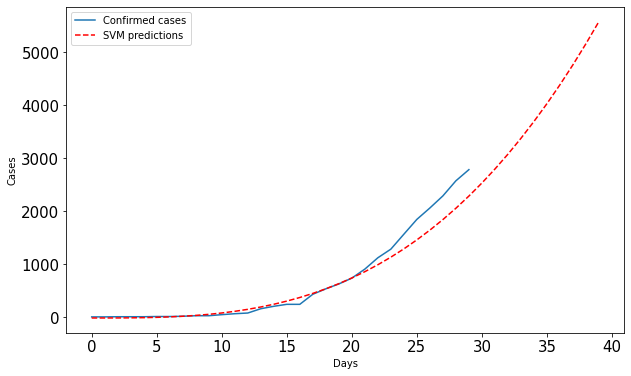

In [13]:
plt.figure(figsize = (10, 6))
plt.plot(adjusted_dates, confirmed)
plt.plot(future_forecast_days, svm_prediction, linestyle='dashed', color='red')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend(['Confirmed cases', 'SVM predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()